In [0]:
#Fetching Data
def fetch():
  import pandas_datareader.data as pdr
  import datetime as dt
  import pandas as pd
  tickers  = ['SBIN.NS'] # Enter all the tickers whose data you require
  stock_cp = pd.DataFrame()
  start_date = dt.date.today() - dt.timedelta(365)  # Enter the Startdate in the form of datetime.date()
  end_date = dt.date.today() # Enter the End Date in the form of datetime.date()
  attempt = 0
  drop = []
  while len(tickers) != 0 and attempt <=5:
    tickers = [j for j in tickers if j not in drop]
    for i in range(len(tickers)):
      try:
        temp = pdr.get_data_yahoo(tickers[i],start_date,end_date)
        temp.dropna(inplace = True)
        #stock_cp[tickers[i]] = temp['Adj Close']
        #stock_low[tickers[i]] = temp['Low']
        #stock_high[tickers[i]] = temp['High']
        drop.append(tickers[i])
      except:
        print(tickers[i],"failed to fetch data.....retrying")
        continue
      attempt+=1
  return pd.DataFrame(temp['Adj Close']), pd.DataFrame(temp['High']), pd.DataFrame(temp['Low']) #stock_cp # stock_low, stock_high

In [0]:
def plots(n):
  import matplotlib.pyplot as plt
  fig, ax = plt.subplots(n, 1, sharex=True)
  fig.set_figheight(10)
  fig.set_figwidth(15)
  fig.subplots_adjust(hspace=0)
  return fig, ax

In [3]:
def ema(span, df=fetch()[0]):
  import pandas as pd
  sma = df.rolling(window=span, min_periods=span).mean()[:span]
  rest = df[span:]
  ema = pd.concat([sma, rest]).ewm(span=span, adjust=False).mean()
  return ema

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


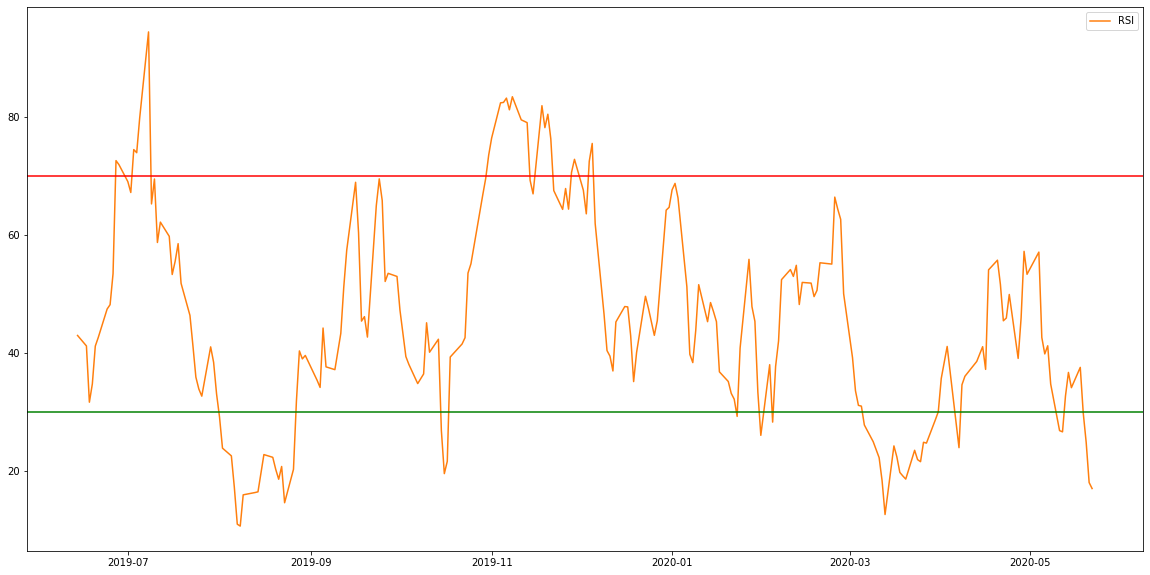

In [4]:
def rsi(df=fetch()[0]):
  import numpy as np
  import pandas as pd
  df['diff'] = df.iloc[:,0].diff()
  df['rsi'] = np.nan
  diff = df.diff()
  for i in range(14, len(diff)):
    diff1 = diff.iloc[i-14:i]
    pos = diff1[diff1.iloc[:,0]>0].sum()[0]
    neg = diff1[diff1.iloc[:,0]<=0].sum()[0]*-1
    ratio = 1 + (pos/neg)
    rsi = 100 - (100/ratio)
    df['rsi'].iloc[i] = rsi
  return pd.DataFrame(df['rsi'])
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(rsi(), 'C1', label = 'RSI')
plt.axhline(y=70, color = 'r')
plt.axhline(y=30, color = 'g')
plt.legend()

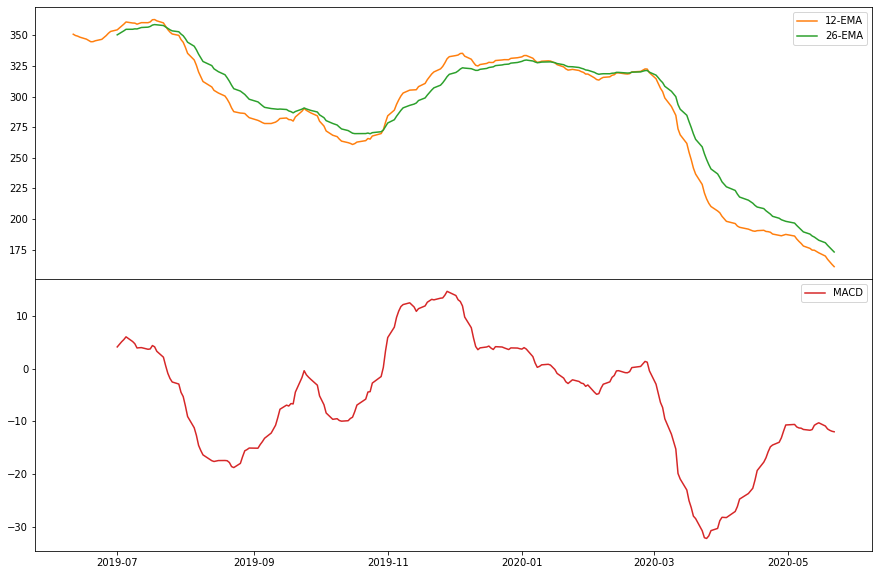

In [5]:
def macd(df=fetch()[0]):
  twelve_ema = ema(12, df)
  twentysix_ema = ema(26, df)
  MACD = twelve_ema - twentysix_ema
  return twelve_ema, twentysix_ema, MACD
fig, ax = plots(2)
ax[0].plot(macd()[0], 'C1', label = '12-EMA')
ax[0].plot(macd()[1], 'C2', label = '26-EMA')
ax[0].legend()
ax[1].plot(macd()[2], 'C3', label = 'MACD')
ax[1].legend()

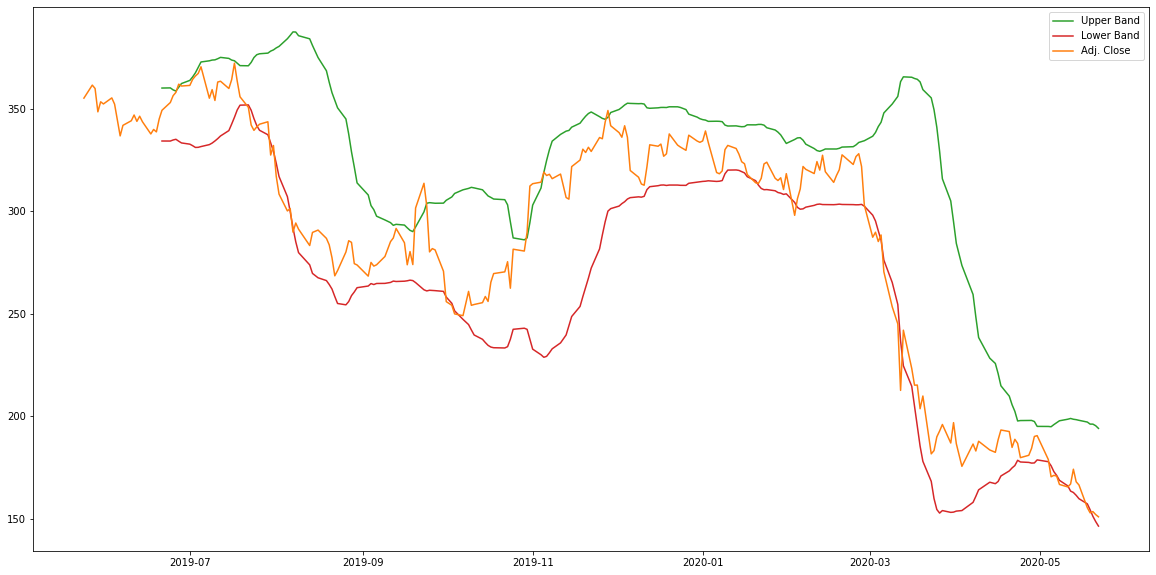

In [6]:
import pandas as pd
def bollingerband(df=pd.concat([fetch()[0], fetch()[1], fetch()[2]], axis = 1, sort = False).mean(axis=1)):
  df=pd.DataFrame(df)
  df.columns = ['TP']
  dfma = df.rolling(window=20).mean()
  pdfsd = 2 * df.rolling(window=20).std()
  upper = dfma + pdfsd
  lower = dfma - pdfsd
  return upper, lower
plt.figure(figsize=(20,10))
plt.plot(bollingerband()[0], 'C2', label = 'Upper Band')
plt.plot(bollingerband()[1], 'C3', label = 'Lower Band')
plt.plot(fetch()[0], 'C1', label = 'Adj. Close')   
plt.legend()

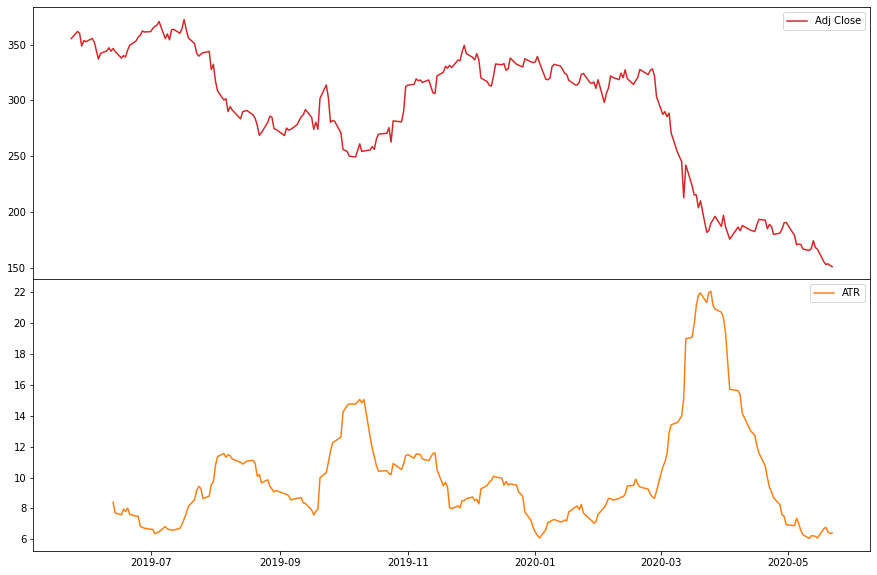

In [7]:
def atr():
  a = abs(fetch()[0]['Adj Close'] - fetch()[2]['Low'])
  b = abs(fetch()[0]['Adj Close'] - fetch()[1]['High'])
  c = (fetch()[1]['High'] - fetch()[2]['Low'])
  df = pd.DataFrame(pd.concat([a,b,c], axis= 1))
  df.columns = ['a', 'b', 'c']
  df["max"] = df.max(axis=1)
  df['ma'] = df['max'].rolling(window=14).mean()
  return df.ma
fig, ax = plots(2)
ax[1].plot(atr(), 'C1', label = 'ATR')
ax[1].legend()
ax[0].plot(fetch()[0], 'C3', label = 'Adj Close')
ax[0].legend()

In [0]:
def adx():
  import numpy as np
  upmove = fetch()[1].diff()
  downmove = fetch()[2].diff()
  adx1 = pd.concat([upmove, downmove], axis = 1)
  adx1['pdm'] = np.nan
  adx1['mdm'] = np.nan
  adx1['pdi'] = np.nan
  adx1['mdi'] = np.nan
  adx1['tr'] = pd.DataFrame(atr())
  adx1['adxs'] = np.nan
  adx1['adx'] = np.nan
  adx1.pdm[(adx1.High > adx1.Low) & (adx1.High>0)] = adx1.High
  adx1.mdm[(adx1.High < adx1.Low) & (adx1.Low>0)] = adx1.Low
  adx1.pdm = adx1.pdm.fillna(0)
  adx1.mdm = adx1.mdm.fillna(0)
  adx1.pdm = adx1.pdm.ewm(span=14, adjust=False).mean()
  adx1.mdm = adx1.pdm.ewm(span=14, adjust=False).mean()
  adx1['pdi'] = 100 * (adx1.pdm/adx1.tr)
  adx1['mdi'] = 100 * (adx1.mdm/adx1.tr)
  adx1.adxs = abs((adx1.pdi-adx1.mdi)/(adx1.pdi+adx1.mdi))
  adx1.adx = 100 * adx1.adxs.ewm(span=14, adjust=False).mean()
  return adx1

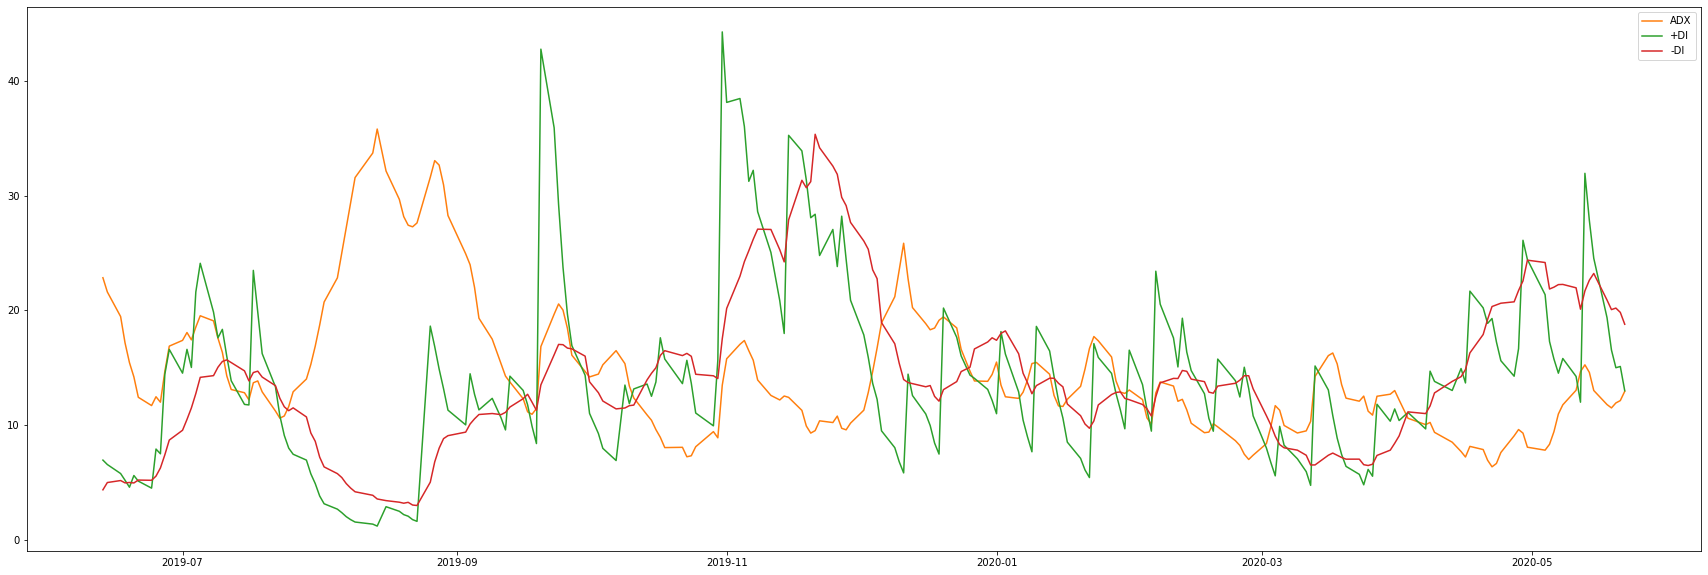

In [9]:
plt.figure(figsize=(30,10))
plt.plot(adx()['adx'], 'C1', label = 'ADX')
plt.plot(adx()['pdi'], 'C2', label = '+DI')
plt.plot(adx()['mdi'], 'C3', label = '-DI')
plt.legend()